In [1]:
#pip install music21

In [30]:
#Import npz data
import numpy as np
import matplotlib.pyplot as plt   
%matplotlib inline
from music21 import *
from IPython.display import Audio
from intervaltree import Interval,IntervalTree
import pandas as pd
import seaborn as sns

from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
import sklearn.model_selection as model_selection

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

from collections import Counter
from imblearn.over_sampling import SMOTE
#from imblearn.over_sampling import SVMSMOTE
from sklearn.model_selection import train_test_split
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


mn_data = np.load('musicnet.npz','rb',allow_pickle=True)

In [31]:
metadata = pd.read_csv('C:/Users/Zhuang/Documents/Berkeley Program/W207 Machine Learning/Final Project/musicnet_metadata.csv',index_col=0)

train_wav = pd.read_csv('C:/Users/Zhuang/Documents/Berkeley Program/W207 Machine Learning/Final Project/df_train_wav_consolidated.csv',index_col=0)
test_wav = pd.read_csv('C:/Users/Zhuang/Documents/Berkeley Program/W207 Machine Learning/Final Project/df_test_wav_finc.csv',index_col=0)


In [32]:
#Make a copy of the metadata
meta_data_copy = metadata.copy(deep=True)
meta_data_copy.reset_index(inplace=True)
#Rename column name
meta_data_copy = meta_data_copy.rename(columns = {'id':'filename'})

merged_train_data = pd.merge(train_wav , meta_data_copy , on="filename")
merged_train_data = merged_train_data.drop(["composer", "composition", "movement","source","transcriber","catalog_name"], axis=1)

merged_test_data = pd.merge(test_wav , meta_data_copy , on="filename")
merged_test_data = merged_test_data.drop(["composer", "composition", "movement","source","transcriber","catalog_name"], axis=1)


In [33]:
#subset of dataset for only max 2 instruments

subset_list= ['Accompanied Cello','Accompanied Clarinet','Accompanied Violin','Solo Cello', 'Solo Flute', 'Solo Piano', 'Solo Violin', 'Violin and Harpsichord']
subset_merged_train_data = merged_train_data.loc[merged_train_data['ensemble'].isin(subset_list)]
subset_merged_test_data = merged_test_data.loc[merged_test_data['ensemble'].isin(subset_list)]

In [34]:
merged_train_data.shape

(320, 169)

In [35]:
#Get list of unique ensembles
ens_list = merged_train_data['ensemble'].unique()
ens_list

array(['Piano Quintet', 'Solo Piano', 'Piano Trio', 'Viola Quintet',
       'String Quartet', 'Clarinet Quintet',
       'Pairs Clarinet-Horn-Bassoon', 'Wind Quintet', 'Accompanied Cello',
       'Accompanied Clarinet', 'Wind and Strings Octet', 'String Sextet',
       'Piano Quartet', 'Horn Piano Trio', 'Solo Violin', 'Solo Flute',
       'Solo Cello', 'Violin and Harpsichord',
       'Clarinet-Cello-Piano Trio', 'Accompanied Violin', 'Wind Octet'],
      dtype=object)

In [36]:
#Map list of unique ensemble names to integer
mapping = {item:i for i, item in enumerate(ens_list)}

#merged_train_data['ensemble'] = merged_train_data.ensemble.map(mapping)

merged_train_data["ensemble"] = merged_train_data["ensemble"].apply(lambda x: mapping[x])
subset_merged_train_data["ensemble"] = subset_merged_train_data["ensemble"].apply(lambda x: mapping[x])

merged_test_data["ensemble"] = merged_test_data["ensemble"].apply(lambda x: mapping[x])
subset_merged_test_data["ensemble"] = subset_merged_test_data["ensemble"].apply(lambda x: mapping[x])

C:\Users\Zhuang\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\Zhuang\anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [37]:
X_original_train = merged_train_data.iloc[:,np.r_[:167,168]]
X_original_test = merged_test_data.iloc[:,np.r_[:167,168]]

y_original_train = merged_train_data.iloc[:,167:168]
y_original_test = merged_test_data.iloc[:,167:168]


In [39]:
#Concatenate the training and test data
x_frames = [X_original_train,X_original_test]
X = pd.concat(x_frames , ignore_index=True)

y_frames = [y_original_train,y_original_test]
y = pd.concat(y_frames , ignore_index=True)




In [40]:
#Find the index position of viola quintet and drop it since there is only one ensemble of that type
index_violaquintet = y[ y['ensemble'] == 3 ].index
y.drop(index_violaquintet , inplace=True)
X.drop(index_violaquintet , inplace=True)




X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, train_size=0.80, test_size=0.20, stratify=y, random_state=101)



In [41]:
print("Before oversampling: ",Counter(y_train.values.ravel()))


Before oversampling:  Counter({1: 125, 4: 46, 19: 18, 16: 10, 14: 7, 7: 7, 12: 6, 8: 6, 2: 6, 6: 5, 11: 4, 20: 3, 13: 3, 0: 3, 9: 3, 17: 3, 10: 2, 5: 2, 15: 2, 18: 2})


In [42]:
print("Before oversampling: ",Counter(y_test.values.ravel()))

Before oversampling:  Counter({1: 31, 4: 11, 19: 4, 14: 2, 7: 2, 12: 2, 16: 2, 9: 1, 0: 1, 15: 1, 13: 1, 11: 1, 6: 1, 8: 1, 2: 1, 18: 1, 17: 1, 20: 1, 5: 1})


In [43]:
#Drop any ensemble types with counts below 6
counts = y_train['ensemble'].value_counts()
X_train = X_train[~y_train['ensemble'].isin(counts[counts < 6].index)]
y_train = y_train[~y_train['ensemble'].isin(counts[counts < 6].index)]

In [44]:
print(X_train.shape, X_test.shape , y_train.shape, y_test.shape)

(231, 168) (66, 168) (231, 1) (66, 1)


In [45]:
# Set some variables to hold test, dev, training and mini_train data.
test_data, test_labels = X[:56], y[:56]
dev_data, dev_labels = X[56:66], y[56:66]
train_data, train_labels = X_train[:231], y_train[:231]
mini_train_data, mini_train_labels = X_train[:10], y_train[:10]


In [46]:
print(mini_train_data.shape, dev_data.shape , mini_train_labels.shape, dev_labels.shape)

(10, 168) (10, 168) (10, 1) (10, 1)


In [47]:


# define oversampling strategy

# fit and apply the transform
X_SMOTE, y_SMOTE = SMOTE().fit_resample(X_train, y_train.values.ravel())

# summarize class distribution
print("After oversampling: ",Counter(y_SMOTE))

After oversampling:  Counter({19: 125, 1: 125, 12: 125, 14: 125, 16: 125, 4: 125, 7: 125, 8: 125, 2: 125})


In [22]:
scaler = MinMaxScaler()

In [48]:

#https://www.baeldung.com/cs/svm-multiclass-classification

rbf = SVC(kernel='rbf', gamma=0.5, C=0.1).fit(X_SMOTE, y_SMOTE)
poly = SVC(kernel='poly', degree=3, C=1).fit(X_SMOTE, y_SMOTE)
poly_pred = poly.predict(X_test)
rbf_pred = rbf.predict(X_test)

In [49]:
poly_accuracy = accuracy_score(y_test, poly_pred)
poly_f1 = f1_score(y_test, poly_pred, average='weighted')
print('Accuracy (Polynomial Kernel): ', "%.2f" % (poly_accuracy*100))
print('F1 (Polynomial Kernel): ', "%.2f" % (poly_f1*100))

Accuracy (Polynomial Kernel):  27.27
F1 (Polynomial Kernel):  25.87


In [50]:
rbf_accuracy = accuracy_score(y_test, rbf_pred)
rbf_f1 = f1_score(y_test, rbf_pred, average='weighted')
print('Accuracy (RBF Kernel): ', "%.2f" % (rbf_accuracy*100))
print('F1 (RBF Kernel): ', "%.2f" % (rbf_f1*100))

Accuracy (RBF Kernel):  46.97
F1 (RBF Kernel):  30.02


In [51]:
svm = SVC(kernel='linear')
svm.fit(X_SMOTE, y_SMOTE)
predictions = svm.predict(X_test)
print('Accuracy score: ', accuracy_score(predictions, np.array(y_test)))
print('F1 Score: ', f1_score(predictions, np.array(y_test), average='weighted'))
print('Classification report: \n', classification_report(y_test, predictions))
print('Confusion Matrix: \n', confusion_matrix(y_test, predictions))

Accuracy score:  0.7878787878787878
F1 Score:  0.8480257116620752
Classification report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.86      0.97      0.91        31
           2       0.33      1.00      0.50         1
           4       0.77      0.91      0.83        11
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         1
           7       1.00      1.00      1.00         2
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         1
          12       1.00      1.00      1.00         2
          13       0.00      0.00      0.00         1
          14       1.00      1.00      1.00         2
          15       0.00      0.00      0.00         1
          16       1.00      1.00      1.00         2
          17       0.00      0.00      0.00 

C:\Users\Zhuang\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Zhuang\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Zhuang\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [26]:
def confusion_matrix_plot(conf_matrix):
    """ Confusion matrix matplotlib plot
    # param conf_matrix: nested list of TP, TN, FP, FN
    # return: None
    """
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i, s=conf_matrix[i, j], va='center', ha='center')

    plt.xlabel('Predicted label')
    plt.ylabel('True label')

    plt.tight_layout()
    plt.show()

    



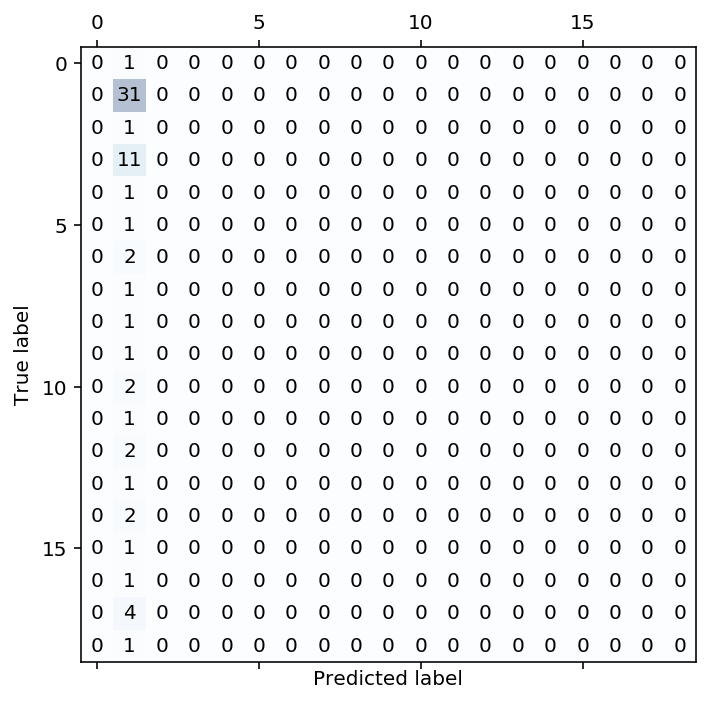

In [24]:
#Run Confusion matrix and plot for rbf kernel SVM
conf_matrix = confusion_matrix(y_test, rbf_pred) 
confusion_matrix_plot(conf_matrix)

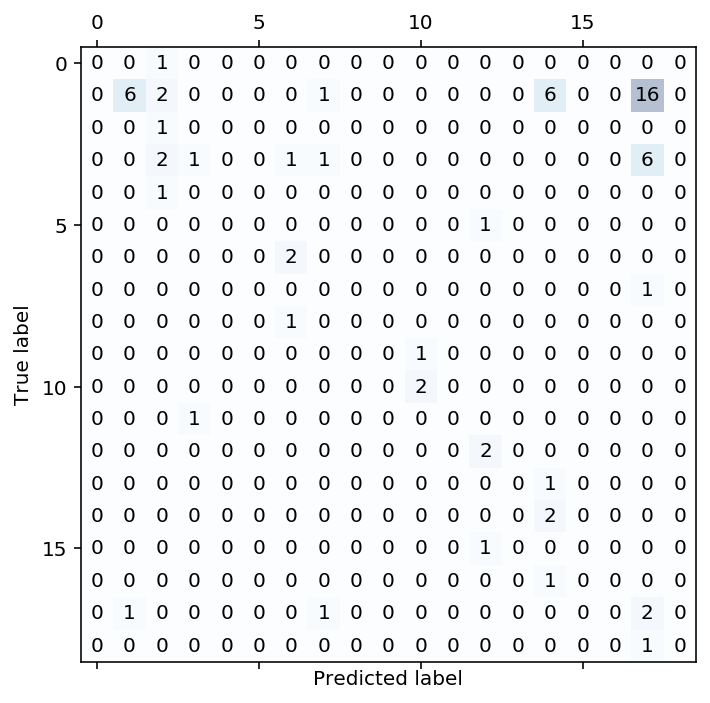

In [27]:
#Run Confusion matrix and plot for poly kernel SVM
conf_matrix = confusion_matrix(y_test, poly_pred) 
confusion_matrix_plot(conf_matrix)

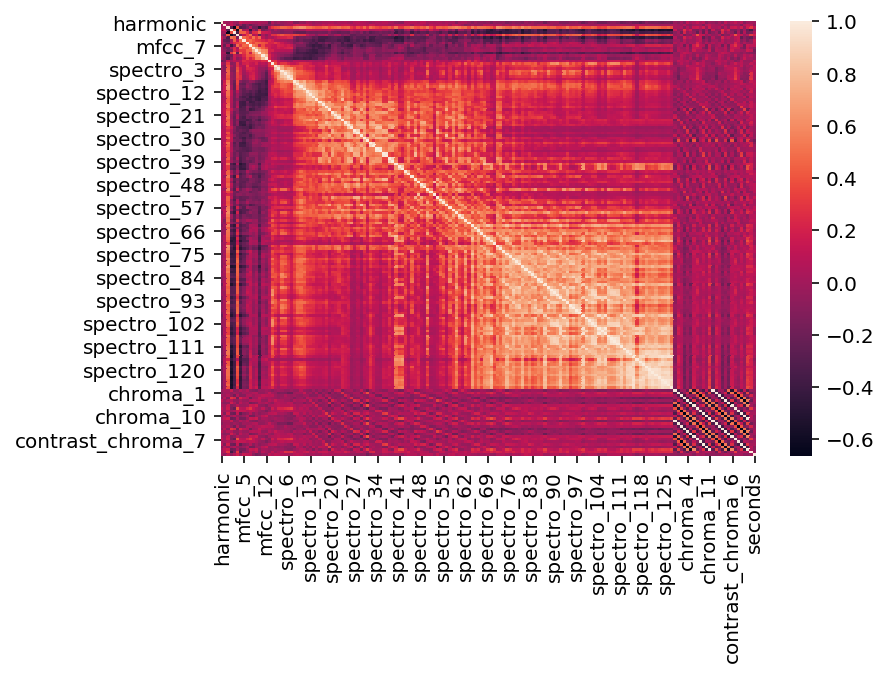

In [26]:
#Correlation Heatmap

# plotting correlation heatmap
dataplot=sns.heatmap(merged_train_data.corr())
  
# displaying heatmap
plt.show()

In [28]:
#Correlation Table

correlation_mat = merged_train_data.corr()

corr_pairs = correlation_mat.unstack()

sorted_pairs = corr_pairs.sort_values(kind="quicksort")

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(sorted_pairs)

chroma_2            chroma_8             -0.665093
                    contrast_chroma_8    -0.665093
contrast_chroma_8   contrast_chroma_2    -0.665093
                    chroma_2             -0.665093
chroma_8            chroma_2             -0.665093
                    contrast_chroma_2    -0.665093
contrast_chroma_2   contrast_chroma_8    -0.665093
                    chroma_8             -0.665093
chroma_4            chroma_10            -0.662990
                    contrast_chroma_10   -0.662990
contrast_chroma_10  chroma_4             -0.662990
chroma_10           chroma_4             -0.662990
                    contrast_chroma_4    -0.662990
contrast_chroma_10  contrast_chroma_4    -0.662990
contrast_chroma_4   chroma_10            -0.662990
                    contrast_chroma_10   -0.662990
chroma_3            contrast_chroma_9    -0.658759
contrast_chroma_9   contrast_chroma_3    -0.658759
chroma_3            chroma_9             -0.658759
chroma_9            chroma_3   

In [28]:
merged_test_data

,harmonic,filename,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,...,contrast_chroma_4,contrast_chroma_5,contrast_chroma_6,contrast_chroma_7,contrast_chroma_8,contrast_chroma_9,contrast_chroma_10,contrast_chroma_11,ensemble,seconds
0,0,1759,-343.203400,186.355377,-4.224813,1.675609,12.931504,-1.158068,-5.180148,-4.976317,...,0.158583,0.209071,0.083379,0.318228,0.218146,0.071587,0.245749,0.115860,1,194
1,1,1819,-369.021576,145.923279,4.006087,-7.556865,-8.294106,-11.409053,-12.574995,-19.553404,...,0.075186,0.286783,0.048316,0.266710,0.183658,0.055202,0.400094,0.113663,6,177
2,1,2106,-325.866852,126.354408,-37.648258,6.182119,-6.480280,-11.131505,-14.435202,-3.484759,...,0.259162,0.140748,0.204958,0.220098,0.142220,0.377379,0.113099,0.156011,4,226
3,1,2191,-352.076141,48.050789,-76.676285,9.126340,-13.951100,-17.007097,-14.569343,-3.089466,...,0.268383,0.127933,0.182810,0.126083,0.194248,0.237331,0.178895,0.395526,14,102
4,1,2298,-318.276703,151.064117,10.386458,16.196163,26.193762,-3.954419,-14.785936,-0.668511,...,0.178822,0.290966,0.285868,0.483256,0.192674,0.139865,0.152334,0.100641,16,153
5,1,2382,-240.444168,105.266556,-21.538193,37.911709,0.582453,-10.857827,0.365906,-5.909674,...,0.137462,0.315506,0.254754,0.397581,0.161606,0.186069,0.362259,0.179021,4,117
6,1,2303,-368.525574,169.655411,-0.348883,-4.402245,4.310961,-9.598778,-9.453362,-9.318494,...,0.295806,0.127156,0.333425,0.196621,0.150811,0.322936,0.099892,0.273327,1,92
7,0,2416,-223.069717,129.685623,-39.956688,-0.564331,-29.567814,-22.458815,-18.999100,-19.777555,...,0.045479,0.347680,0.119385,0.285871,0.227442,0.148438,0.386087,0.067058,6,139
8,1,2556,-346.456146,176.933121,-7.661911,-1.755977,3.870136,-5.701828,-10.607601,-9.144874,...,0.293673,0.168780,0.359411,0.288274,0.115209,0.180869,0.137521,0.382371,1,151
9,1,2628,-251.715363,196.217178,-10.743304,6.727445,-8.804654,-16.863007,-12.412786,-16.205635,...,0.096805,0.252042,0.181751,0.360087,0.181775,0.214431,0.339093,0.109427,19,124


## Data Exploration

In [29]:
print('Number of recordings: ' + str(len(mn_data.files)))
print('Example MusicNet ids: ' + str(list(mn_data.keys())[0:5]))

Number of recordings: 330
Example MusicNet ids: ['1788', '1789', '2659', '2127', '1818']


In [30]:
#defining function to read MIDI files
def read_midi(file):
    
    print("Loading Music File:",file)
    
    notes=[]
    notes_to_parse = None
    
    #parsing a midi file
    midi = converter.parse(file)
  
    #grouping based on different instruments
    s2 = instrument.partitionByInstrument(midi)

    #Looping over all the instruments
    for part in s2.parts:
        #print(part)
        #select elements of only piano
        if 'Piano' in str(part): 
        
            notes_to_parse = part.recurse() 
      
            #finding whether a particular element is note or a chord
            for element in notes_to_parse:
                
                #note
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))
                
                #chord
                elif isinstance(element, chord.Chord):
                    notes.append('.'.join(str(n) for n in element.normalOrder))

    return np.array(notes)

In [31]:
#for listing down the file names
import os

#Array Processing
import numpy as np

#specify the path
path='C:/Users/Zhuang/Documents/Berkeley Program/W207 Machine Learning/Final Project/'

#read all the filenames
files=[i for i in os.listdir(path) if i.endswith(".mid")]

#reading each midi file
notes_array = np.array([read_midi(path+i) for i in files])

Loading Music File: C:/Users/Zhuang/Documents/Berkeley Program/W207 Machine Learning/Final Project/1727_schubert_op114_2.mid
Loading Music File: C:/Users/Zhuang/Documents/Berkeley Program/W207 Machine Learning/Final Project/1728_schubert_op114_3.mid
Loading Music File: C:/Users/Zhuang/Documents/Berkeley Program/W207 Machine Learning/Final Project/1729_schubert_op114_4.mid
Loading Music File: C:/Users/Zhuang/Documents/Berkeley Program/W207 Machine Learning/Final Project/1730_schubert_op114_5.mid
Loading Music File: C:/Users/Zhuang/Documents/Berkeley Program/W207 Machine Learning/Final Project/1733_sy_sps92.mid
Loading Music File: C:/Users/Zhuang/Documents/Berkeley Program/W207 Machine Learning/Final Project/1734_sy_sps93.mid
Loading Music File: C:/Users/Zhuang/Documents/Berkeley Program/W207 Machine Learning/Final Project/1735_sy_sps94.mid
Loading Music File: C:/Users/Zhuang/Documents/Berkeley Program/W207 Machine Learning/Final Project/1739_sb99m4.mid
Loading Music File: C:/Users/Zhuan

In [32]:
import pandas as pd
import seaborn as sns


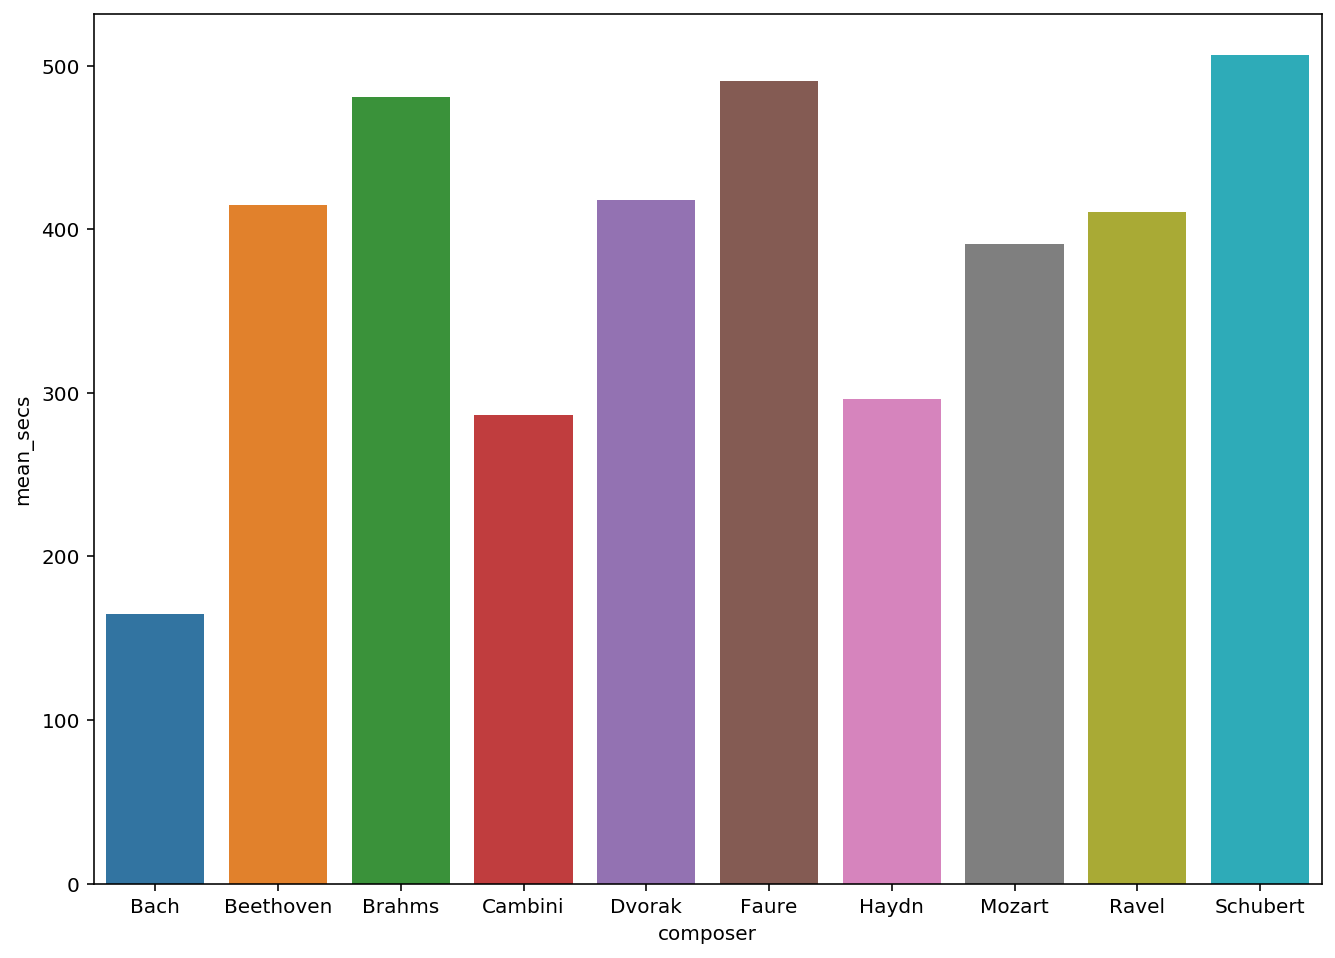

In [33]:
metadata=pd.read_csv('musicnet_metadata.csv')
m1 = metadata.groupby(['composer']).agg(mean_secs=('seconds','mean'))
m1= m1.reset_index()
dims = (11,8)
fig, ax = plt.subplots(figsize=dims)
sns.barplot(ax=ax,x="composer",y="mean_secs",data=m1)